In [1]:
# Import Dependencies
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import random
import transformers
import torchvision.models as models
import torchvision.transforms.functional as vison_functions
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights


KeyboardInterrupt



In [ ]:
# If GPU is available then use GPU
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# Import BERT tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)

# specify hyper parameters
max_token_length = 20
vocab_size = 30522
batch_size = 20
embed_size= 512
hidden_size= 512
epochs = 0
learning_rate = 0.00000001
load_model = True

In [ ]:
# specify path so it's easier to load model later
saved_model_path = "saved_model.pt"

# specify path to custom dataset
data_dir = '../data/DecodingAI'
image_dir = f'{data_dir}/images'
csv_file = f'{data_dir}/dataset.csv'

# create a pandas dataframe from imported dataset
df = pd.read_csv(csv_file,  delimiter="~", names=['image', 'caption'], header=None)
df['image'] = image_dir+'/'+df['image']
df.head(5)

In [ ]:
## Obtain Train Test Split 
train, test = train_test_split(df, test_size=0.01, random_state=1234) #change to 0.2

## Reset Indexes 
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Obtain Validation and Test Split 
val, test = train_test_split(test, test_size=0.01, random_state=1234) #change to 0.5

## Reset Indexes 
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

## Let's see how many entries we have
print(train.shape)
print(val.shape)
print(test.shape)

In [ ]:
# Mehtod allows us to resize all images to be the same dimention while aslo not losing any detail
# since we are not cropping images, instead rezining and then adding padding if demintions are smaller
# than preferred dimentions
class ImgSquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return vison_functions.pad(image, padding, 0, 'constant')

# Resizes and normalizes images
def ResizeAndNormalize(image):
    transform = transforms.Compose([
                ImgSquarePad(),
                transforms.Resize(300),                          # smaller edge of image resized to 325
                transforms.CenterCrop(300),                      # get 224x224 crop from random location
                transforms.ToTensor(),                           # convert the PIL Image to a tensor
                transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                                     (0.229, 0.224, 0.225))])
    return transform(image)

# Creates image caption pairs, while also encoding the captions with BERT
class AIDataset(Dataset):
    
    def __init__(self, df, train):
        self.df = df
        self.captions = self.df['caption']
        self.images = self.df['image']

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        label = self.captions[index]
        image_name = self.images[index]
        image = Image.open(image_name).convert("RGB")
        image = ResizeAndNormalize(image)
        encoded_labels = tokenizer(label, 
                              return_token_type_ids = False, 
                              return_attention_mask = False, 
                              max_length = max_token_length, 
                              padding = "max_length",
                              truncation = True,
                              return_tensors = "pt")
        return image.to(device),  encoded_labels["input_ids"].flatten().to(device)

In [ ]:
# Applies class defined above to train, val, and test dataset and then adds them to the pytorch dataloader
train_dataset = AIDataset(train, True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, drop_last=True)

val_dataset = AIDataset(val, False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size,drop_last=True)

test_dataset = AIDataset(test, False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,drop_last=True)

In [ ]:
# get an image from training data
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
# get some random training images and captions from the train data loader
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show image and cpation
imshow(torchvision.utils.make_grid(images[3]))
original_tokens = tokenizer.decode(labels[3])
print(original_tokens)

In [ ]:
# We are using the EfficientNetB3 pretrained CNN, but we are finetuning the last two layers
# which are the linear layer and the dropout layer
class CNN(nn.Module):
    
    def __init__(self, embed_size):
        super().__init__()
        model = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad_(False)
        
        modules = list(model.children())[:-1]
        self.model = nn.Sequential(*modules)
        self.dropout = nn.Dropout(0.3)
        self.embed = nn.Linear(model.classifier[1].in_features, embed_size)
        
    def forward(self, images):
        features = self.model(images)
        features = features.view(features.size(0), -1)
        features = self.dropout(features)
        features = self.embed(features)
        return features

In [11]:
# We are using a custom LSTM with 512 hidden size
# note: this LSTM is not bidirectional
class RNN(nn.Module):
    
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, features, labels):
        features = features.unsqueeze(1)
        embed = self.embedding(labels)
        embed = torch.cat((features,embed), dim=1)
        lstm_out, _ = self.lstm(embed)
        outputs = self.fc(lstm_out)
        outputs = outputs.view(-1, self.vocab_size)
        return outputs

In [12]:
# This class connects the output of the CNN (ecnoder) into the input of the LSTM (decoder) we are using
class CNN2RNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.encoder = CNN(embed_size)
        self.decoder = RNN(embed_size, hidden_size, vocab_size)
    
    def forward(self, images, labels):
        features = self.encoder(images)
        out = self.decoder(features, labels)
        return out
    
    # Class is used to get promt from image after model is trained
    def captionImage(self, image, max_token_length):
        with torch.no_grad():
            token_ids = []
            image = ResizeAndNormalize(image).unsqueeze(0).to(device)
            x = self.encoder(image)
            h0c0 = None
            for _ in range(max_token_length):
                hiddens, h0c0 = self.decoder.lstm(x, h0c0)
                output = self.decoder.fc(hiddens)
                predicted = output.argmax(1)
                token_ids.append(predicted)
                x = self.decoder.embedding(predicted)
            token_ids = torch.stack(token_ids)
            token_ids = token_ids.view(-1)
            return tokenizer.decode(token_ids)

In [13]:
# Loop used for while training model only
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (images, labels) in enumerate(dataloader):
       
        # Forward
        pred = model(images, labels[:, :-1])
        loss = loss_fn(pred, labels.view(-1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print Progress
        if (batch+1) % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(images)
            print(f"Progress:[{current:>5d}/{size:>5d}] loss:{loss:>10f}")
            
    # same model after each batch is trained       
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, saved_model_path)

# Loop used for validation and test dataset
def test_loop(dataloader, model, loss_fn, dataloader_type):
    model.eval()
    # Initilialize vairables
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            # Send data to same device as model
            pred = model(images, labels)
            
            # Accumalate accuracy and loss
            test_loss += loss_fn(pred, labels.view(-1)).item()
            correct += (pred.argmax(1) == labels.view(-1)).type(torch.float).sum().item()

    # Normalize accuracy and loss
    test_loss /= num_batches
    correct /= size * max_token_length

    # Print test accuracy and averge loss
    print(f"{dataloader_type} Error: Accuracy:{(100*correct):>0.1f}%, Avg loss:{test_loss:>8f} \n")

In [14]:
# specify model, loss function, & optimizer
model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size)
model.to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# get saved model before training
if load_model: 
    checkpoint = torch.load(saved_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
# start training model
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn, "Val")
    
# test model metrics on test dataset
test_loop(test_dataloader, encoder, decoder, loss_fn, "Test")
print("Done!")

Done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


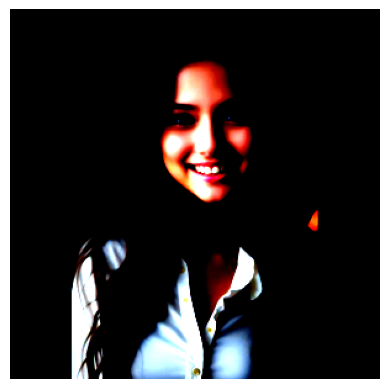

[CLS] a detailed illustration face ninja cat, fire, t - shirt design, flowers splash, t [SEP]


In [37]:
# Use model: get a prompt given AI generated image
image1 = Image.open('img11.jpg')
img = ResizeAndNormalize(image1).to(device)
imshow(torchvision.utils.make_grid(img))
pred = model.captionImage(image1, max_token_length)
print(pred)